# Assignment-1: Computational Genomics
## Task 1.1
A dataset "dataset.h5ad" has been provided, which contains a single-cell gene expression matrix. The following are the tasks to be performed on this dataset. 
1. Quality control, normalization, feature selection and PCA.
2. Following this, data is to be clustered using the Leiden Clustering Algorithm. 
3. Differential expression analysis is to be performed upon each cluster to identify the marker genes.  
4. Based on the marker genes identified, the clusters obtained are to be annotated. 



### Loading the Dataset

In [1]:
pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.3 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8024 sha256=cac435dab5019c8081be53d8abdb8f3f296df59de63f8f9ec133aae3870cf6d4
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [2]:
import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
matrix = sc.read('/kaggle/input/sequencingdata/dataset.h5ad')
matrix

AnnData object with n_obs × n_vars = 10727 × 12303

What does this output mean? 
- n_obs refers to the number of cells. Hence, here we have 10,727 cells. 
- n_vars refers to the number of genes. This matrix contains details about 12,303 genes. 

Inspecting the AnnData object. 

In [4]:
matrix.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '12293', '12294', '12295', '12296', '12297', '12298', '12299', '12300',
       '12301', '12302'],
      dtype='object', length=12303)

In [5]:
matrix.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '10717', '10718', '10719', '10720', '10721', '10722', '10723', '10724',
       '10725', '10726'],
      dtype='object', length=10727)

Adding the gene IDs provided.

In [6]:
gene_IDs = pd.read_csv('/kaggle/input/sequencingdata/gene_names.csv')
gene_IDs

,0
0,LINC00115
1,FAM41C
2,SAMD11
3,NOC2L
4,KLHL17
...,...
12298,YBEY
12299,PCNT
12300,DIP2A
12301,S100B


In [7]:
matrix.var_names = gene_IDs['0'].values
matrix.var_names

Index(['LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       'ISG15', 'AGRN', 'TTLL10',
       ...
       'COL6A2', 'FTCD', 'LSS', 'MCM3AP-AS1', 'MCM3AP', 'YBEY', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=12303)

### Quality Control
Finding the mitochondrial, ribosomal and hemoglobin genes. 

In [8]:
# mitochondrial genes
matrix.var["mt"] = matrix.var_names.str.startswith("MT-")
# ribosomal genes
matrix.var["ribo"] = matrix.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
matrix.var["hb"] = matrix.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    matrix, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

The function above, adds the qc metrics to our AnnData object. The log1p=True returns the logarithm of the results (log(1+x)), which accounts for skewed distrubutions. 

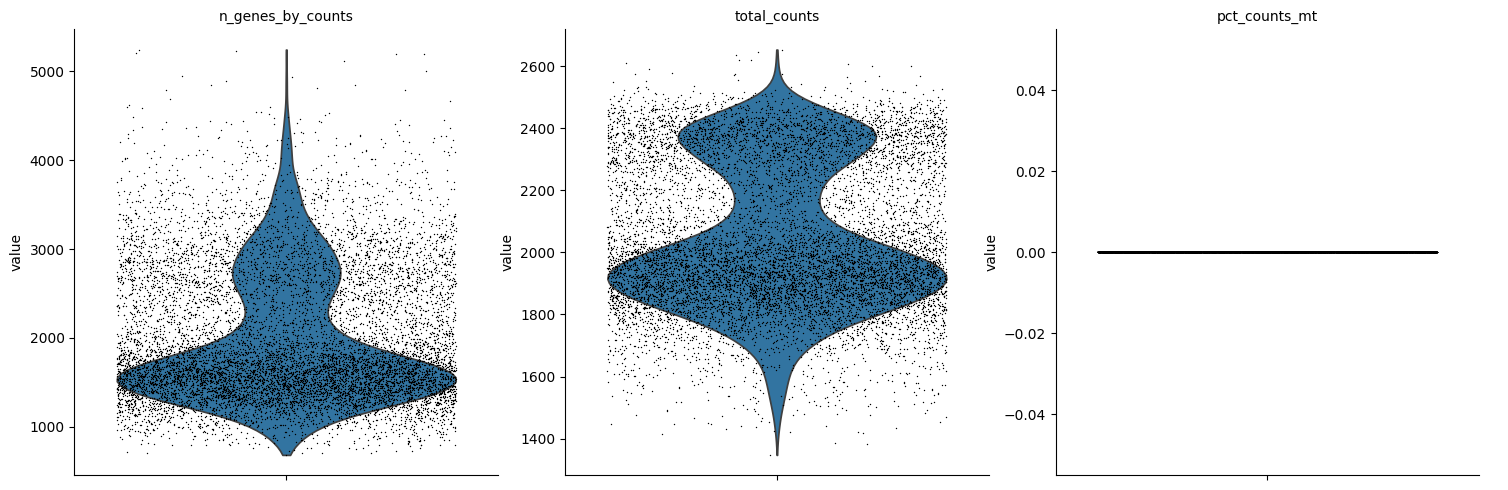

In [9]:
sc.pl.violin(
    matrix,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

It is clear from the above violin plots that there are no mitochondrial genes expressed. 

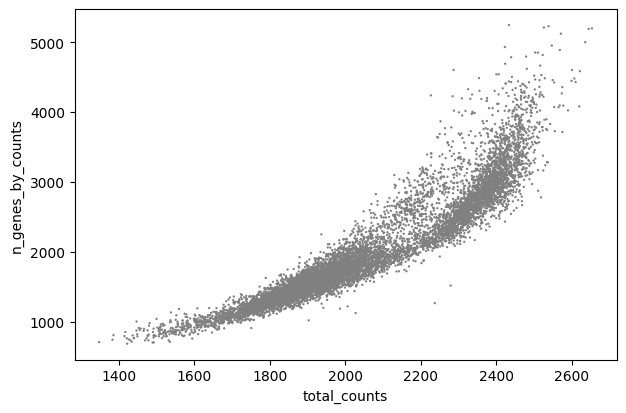

In [10]:
sc.pl.scatter(matrix, "total_counts", "n_genes_by_counts")

To choose apt quality control thresholds, it may be helpful to draw histograms. 

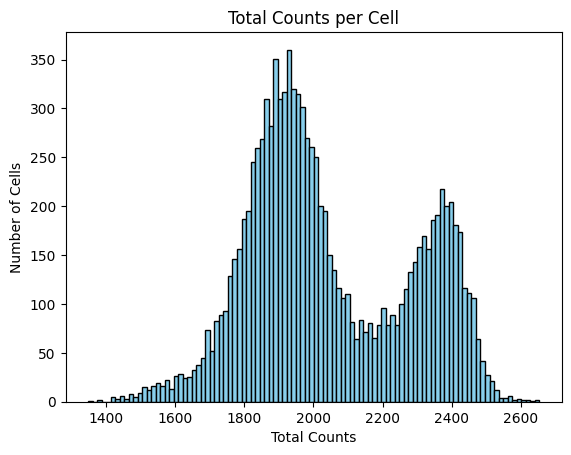

In [11]:
# Plot a histogram of total counts
plt.hist(matrix.obs['total_counts'], bins=100, color='skyblue', edgecolor='black')
plt.title('Total Counts per Cell')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')
plt.show()

There seems to be a noise peak in the above plot below the value of 1400 total counts. 

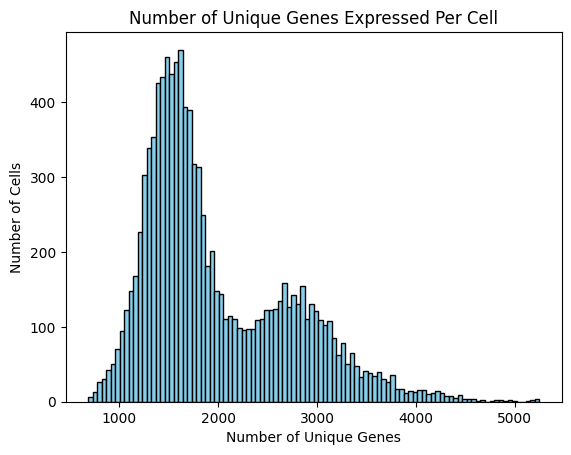

In [12]:
# Plot a histogram of number of genes per barcode
plt.hist(matrix.obs['n_genes_by_counts'], bins=100, color='skyblue', edgecolor='black')
plt.title('Number of Unique Genes Expressed Per Cell')
plt.xlabel('Number of Unique Genes')
plt.ylabel('Number of Cells')
plt.show()

In this graph there is no apparent noise peak on the lower end. 

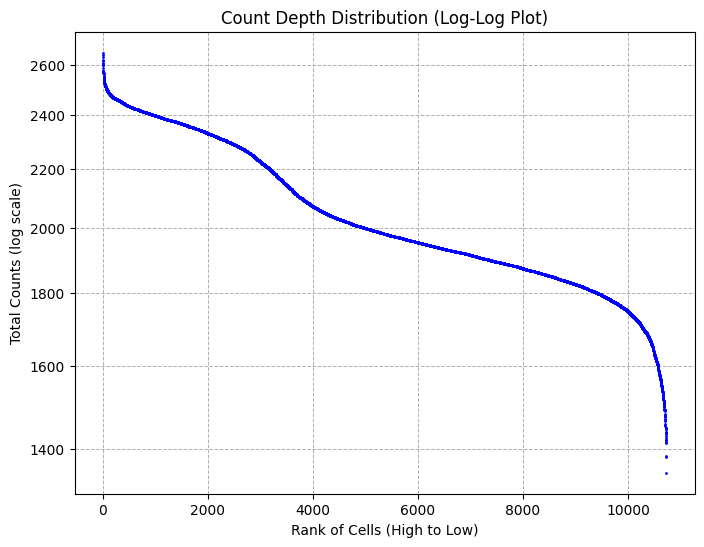

In [13]:
TotalCounts = matrix.obs['total_counts'].values
sorted_counts = np.sort(TotalCounts)[::-1]
ranks = np.arange(1, len(sorted_counts) + 1)
plt.figure(figsize=(8, 6))
plt.plot(ranks, sorted_counts, marker='o', linestyle='none', color='blue', markersize=1)
plt.yscale('log')
plt.xlabel('Rank of Cells (High to Low)')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs='auto'))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_formatter(ticker.LogFormatter(base=10.0))
plt.ylabel('Total Counts (log scale)')
plt.title('Count Depth Distribution (Log-Log Plot)')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()

In the above graph, the "Elbow" is around 1600 total counts.

### Doublet Detection
Making use of Scrublet - the nearest neighbour based doublet detection algorithm.

In [14]:
sc.pp.scrublet(matrix)
np.sum(matrix.obs['predicted_doublet'])

161

Hence, 161 doublets have been detected.

### Normalization


In [15]:
#Saving the raw counts
matrix.layers["counts"] = matrix.X.copy()
# Normalizing to median total counts and transforming it to log(1+x)
sc.pp.normalize_total(matrix)
sc.pp.log1p(matrix)

### Feature Selection
This step is to reduce the dimensions of the matrix such that only the most informative genes are retained. Scanpy automatically annotates the highly variable genes using variance to mean ratios. Usually, erring towards the removal of a larger number of highly variable genes often produces the best results. Hence, here we choose the top 2000 most variable genes.   

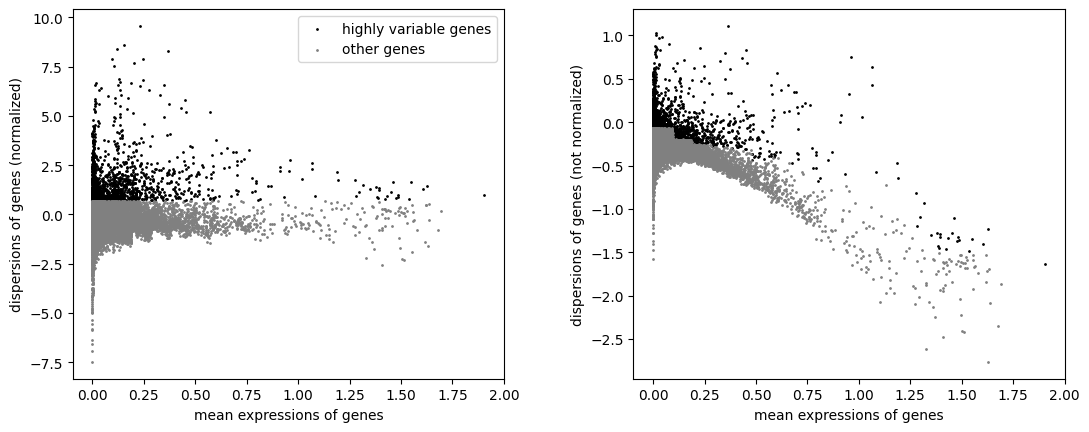

In [16]:
sc.pp.highly_variable_genes(matrix, n_top_genes=2000)
sc.pl.highly_variable_genes(matrix)

To be even safer, let us view the top 5000 highly variable genes. 

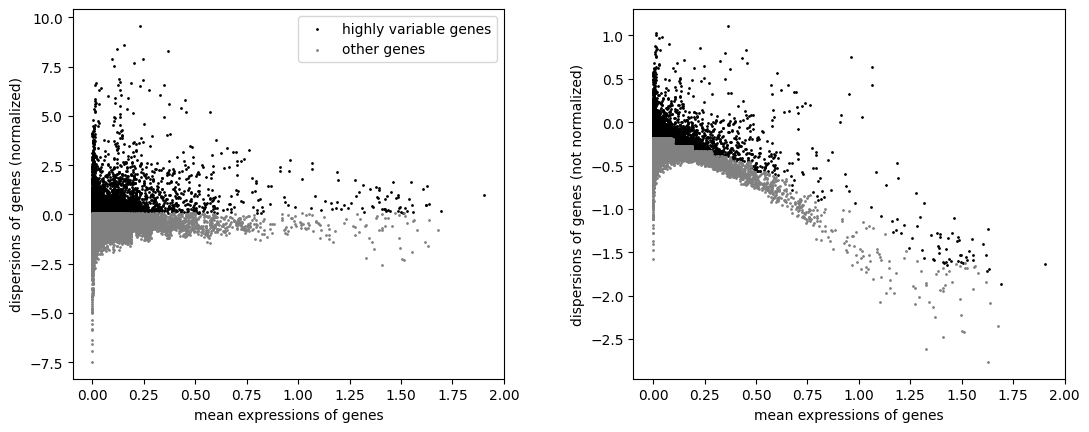

In [17]:
sc.pp.highly_variable_genes(matrix, n_top_genes=5000)
sc.pl.highly_variable_genes(matrix)

In [18]:
matrix

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'

As visible, the 'highly_variable' key has now been added to var. 

### Dimensionality Reduction
Performing Principal Component Analysis (PCA).

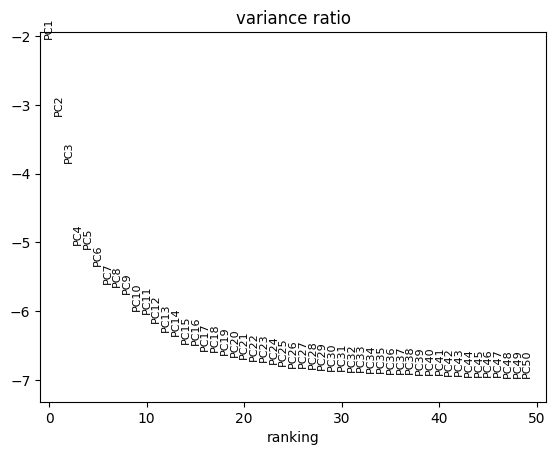

In [19]:
matrix = matrix.copy()
sc.tl.pca(matrix)
sc.pl.pca_variance_ratio(matrix, n_pcs=50, log=True)


The "elbow" of the above curve is around the region of 10-11 principal components. Since there are no pronounced disadvantages of overestimating the principal components, we can fix the value at 30 principal components.

In [20]:
sc.pp.pca(matrix, n_comps = 30)

### Constructing the Nearest Neighbours Graph


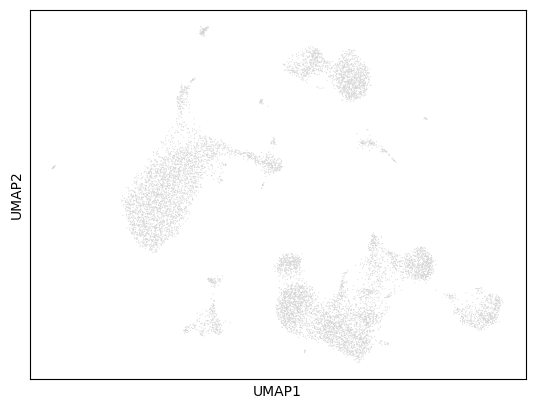

In [21]:
sc.pp.neighbors(matrix)
sc.tl.umap(matrix)
sc.pl.umap(matrix, size = 2,)

### Visualizing the QC Metrics

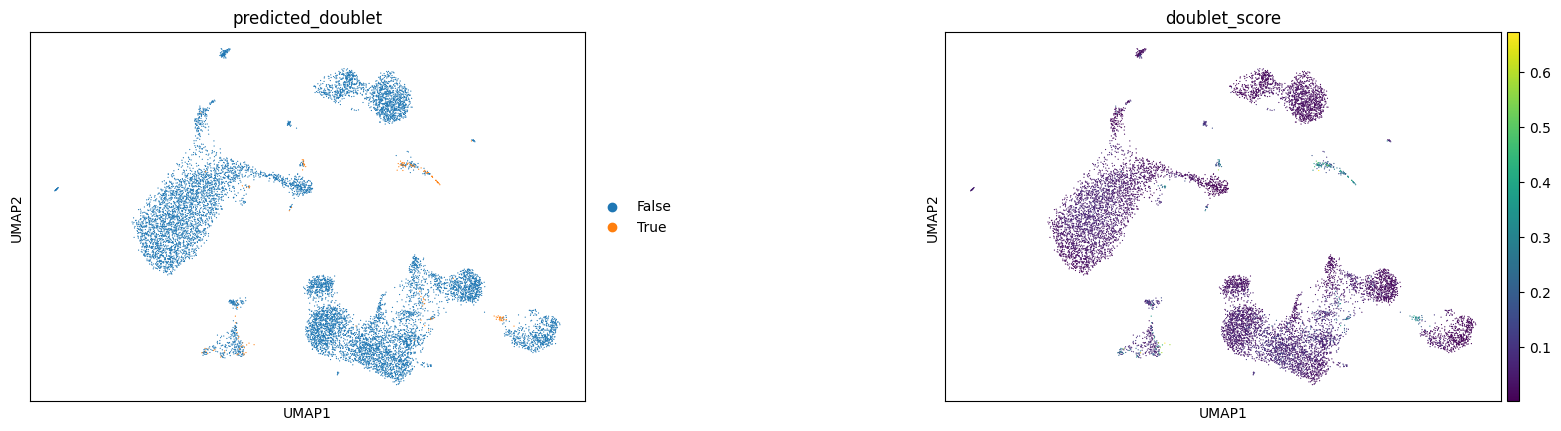

In [22]:
sc.pl.umap(
    matrix,
    color=["predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

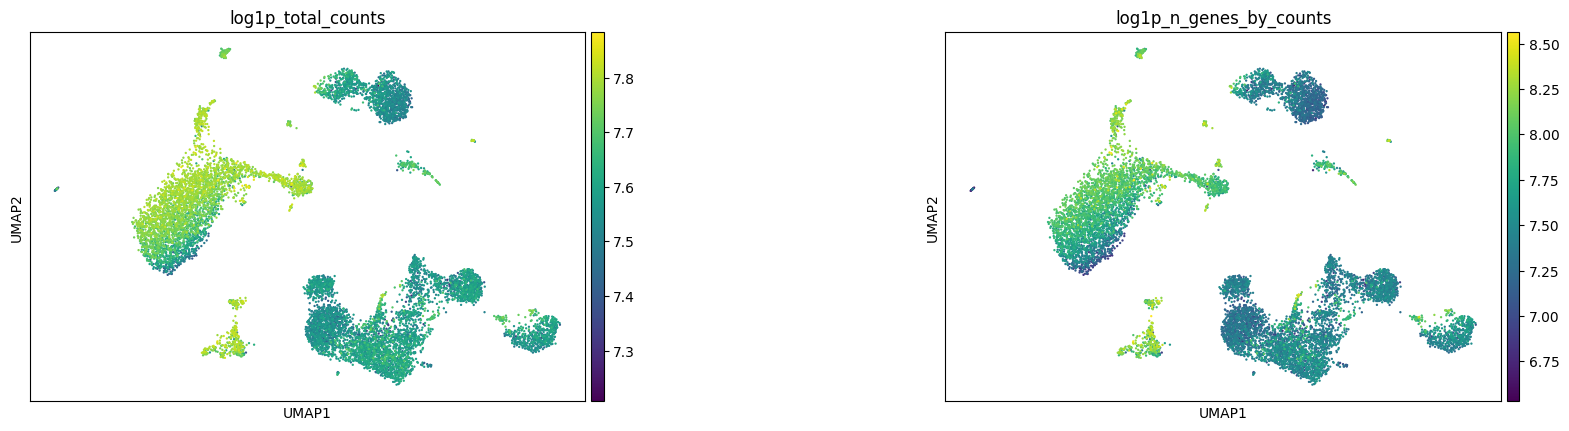

In [23]:
sc.pl.umap(
    matrix,
    color=["log1p_total_counts", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

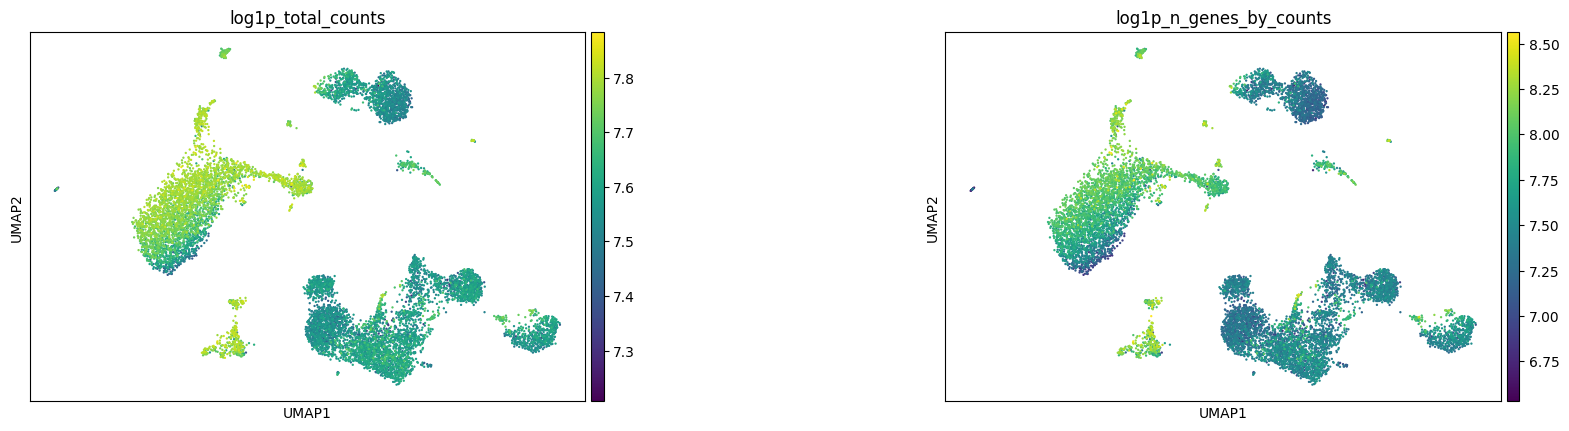

In [24]:
sc.pl.umap(
    matrix,
    color=["log1p_total_counts", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

Let us now find the highly variable genes for clustering.

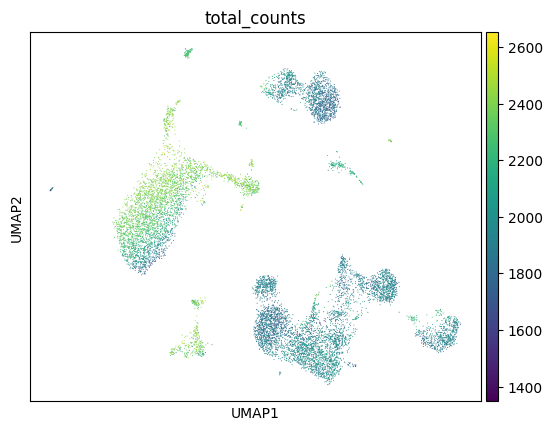

In [25]:
#5000
sc.pp.highly_variable_genes(matrix, n_top_genes=5000)
matrix_5000 = matrix[:, matrix.var["highly_variable"]]
sc.pp.neighbors(matrix_5000)
sc.tl.umap(matrix_5000)
sc.pl.umap(matrix_5000, color = ['total_counts'], size = 2,)


In [26]:
matrix_5000

AnnData object with n_obs × n_vars = 10727 × 5000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'predicted_doublet_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [27]:
matrix = matrix_5000

# Clustering
Making use of leiden clustering. Let us observe how the clusters form at multiple different resolutions. 

In [28]:
for res in [0.05, 0.1, 0.20, 0.25, 0.30, 1.0, 2.0]:
    sc.tl.leiden(
        matrix, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

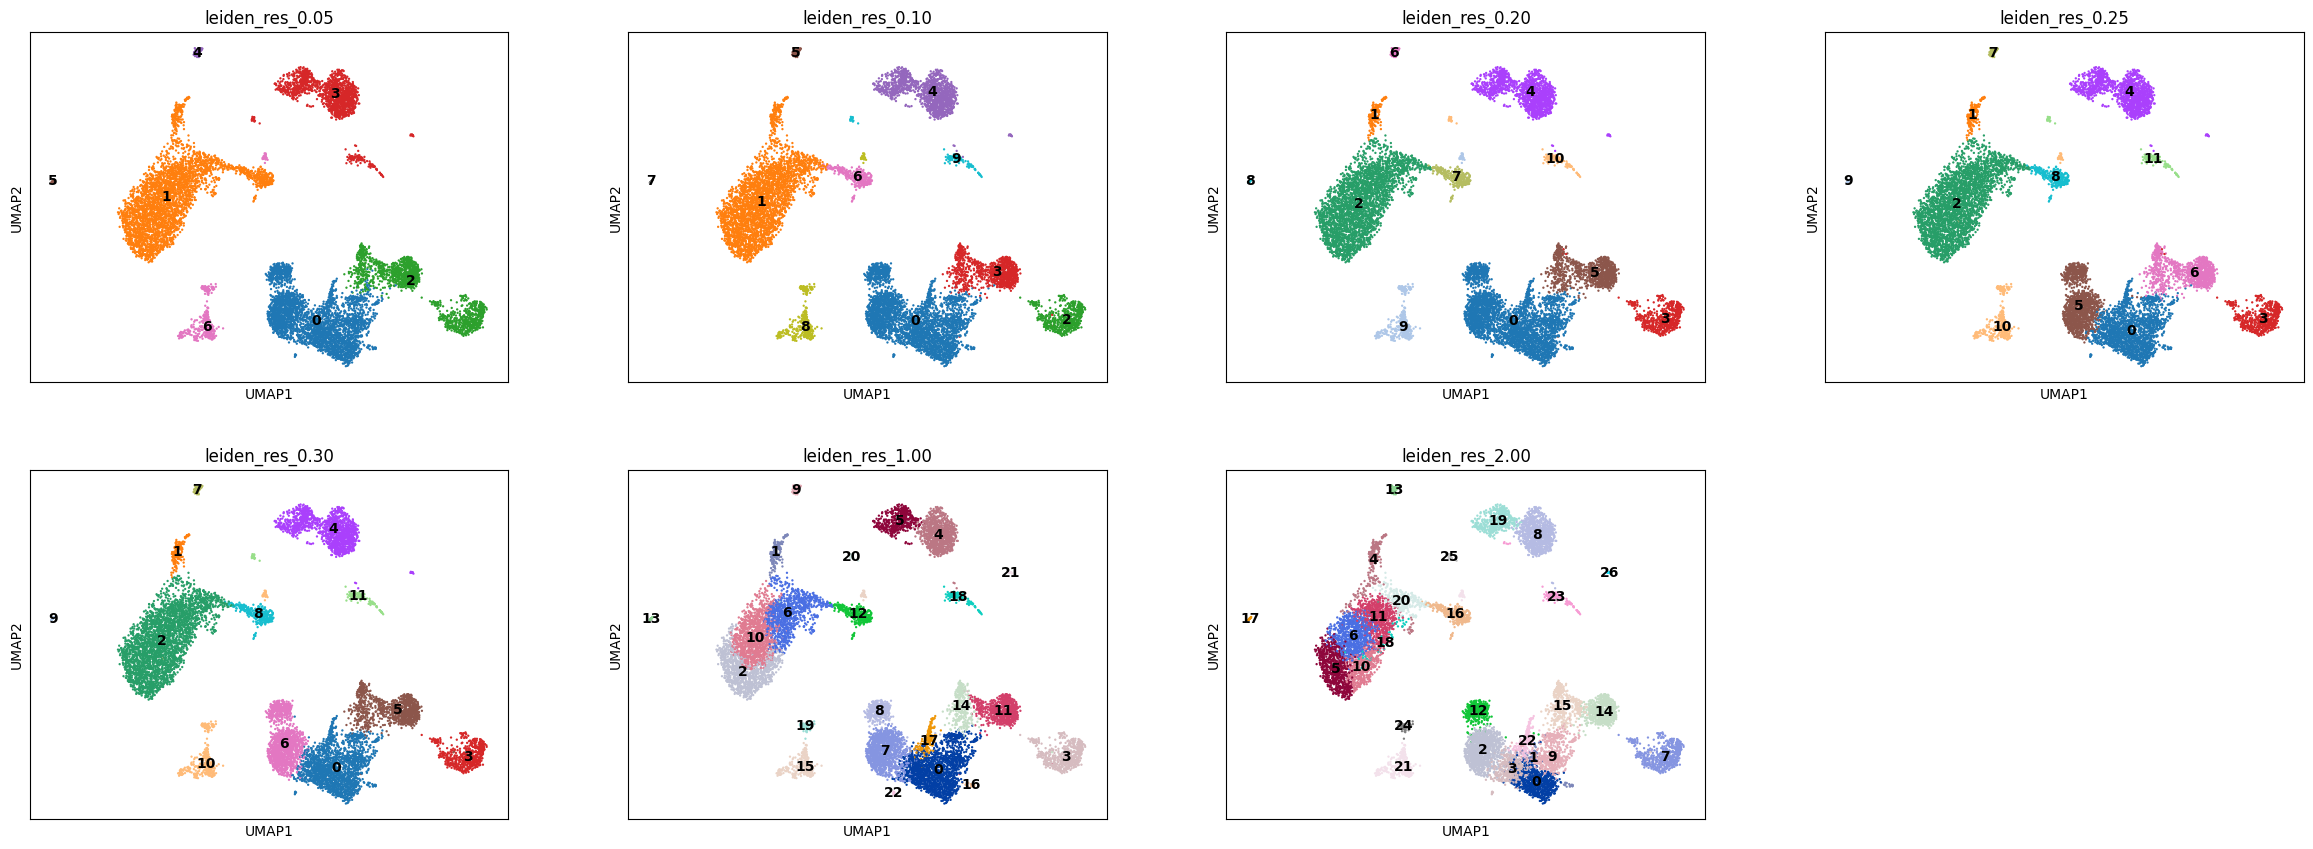

In [29]:
sc.pl.umap(
    matrix,
    color=["leiden_res_0.05", "leiden_res_0.10", "leiden_res_0.20", "leiden_res_0.25", "leiden_res_0.30", "leiden_res_1.00", "leiden_res_2.00" ],
    legend_loc="on data",
)

All clusters above 0.2 seem somewhat overclustered. Let us work further with the 0.20 resolution Leiden clusters.

In [30]:
#Obtaining Output Data
leiden_out = matrix.obs['leiden_res_0.20']
leiden_df = pd.DataFrame(leiden_out)
leiden_df.to_csv('leiden-0.20.csv', index=True)


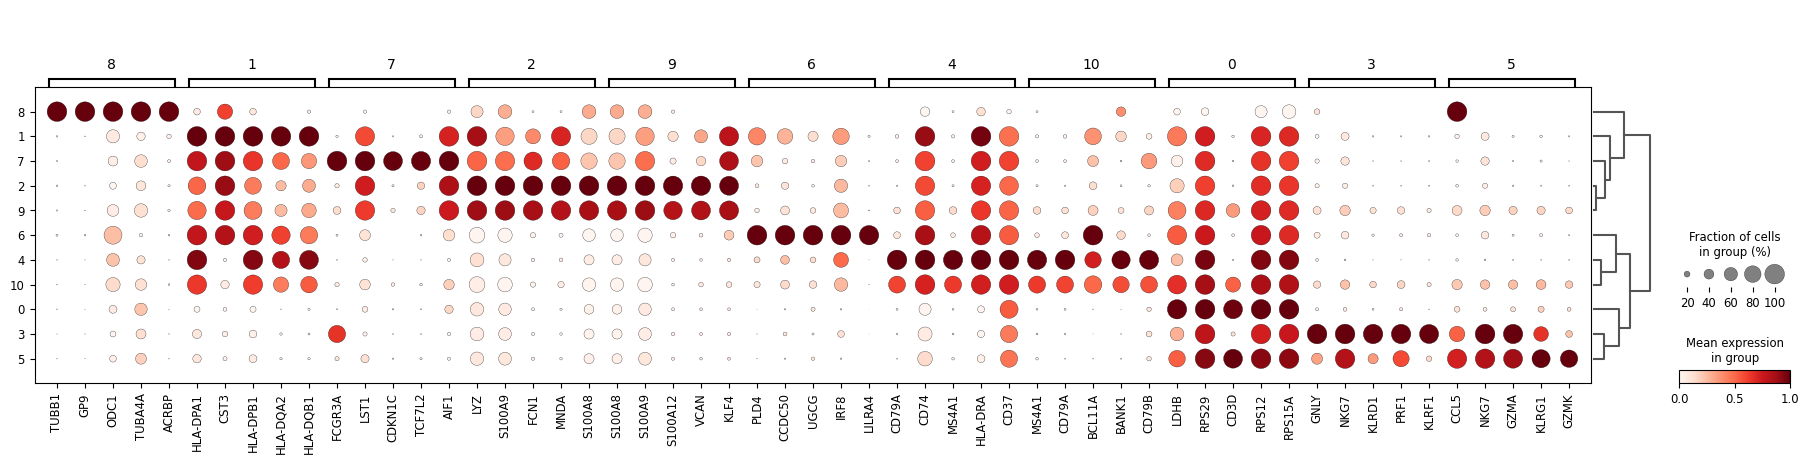

In [31]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(matrix, groupby="leiden_res_0.20", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    matrix, groupby="leiden_res_0.20",standard_scale="var", n_genes=5
)

Searching the differentially expressed genes with PanglaoDB, we can manually annotate the clusters produced.